## Accelerating Metal-Organic Framework Discovery via Synthesisability Prediction: The MFD Evaluation Method for One-Class Classification Models

Chi Zhang, Dmytro Antypov, Matthew J. Rosseinsky, and Matthew S. Dyer*<br/>
Email: M.S.Dyer@liverpool.ac.uk <br/>

Please cite the corresponding paper if you use the Maximum Fractional Difference (MFD) method in your work.<br/>

### The Notebook hereafter presents the code to calculate MFD and OT(the optimal threshold) values.

This notebook requires two input files: the prediction results of your ground_truth dataset and the query dataset. Here we use the results of our best performing model predicting MOF synthesisability as an example.

### Please input your data before calculation.

In [1]:
#import libraries
import pandas as pd
import numpy as np

#from sklearn.preprocessing import scaler Methods
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt 
from matplotlib import cm
import itertools
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from sklearn import datasets, metrics
from numpy import nan as NaN

In [3]:
#import predictions for your ground_truth data and query data 
train_result = pd.read_csv('Your ground_truth data predictions', index_col=0)
test_result = pd.read_csv('Your query data predictions', index_col=0)

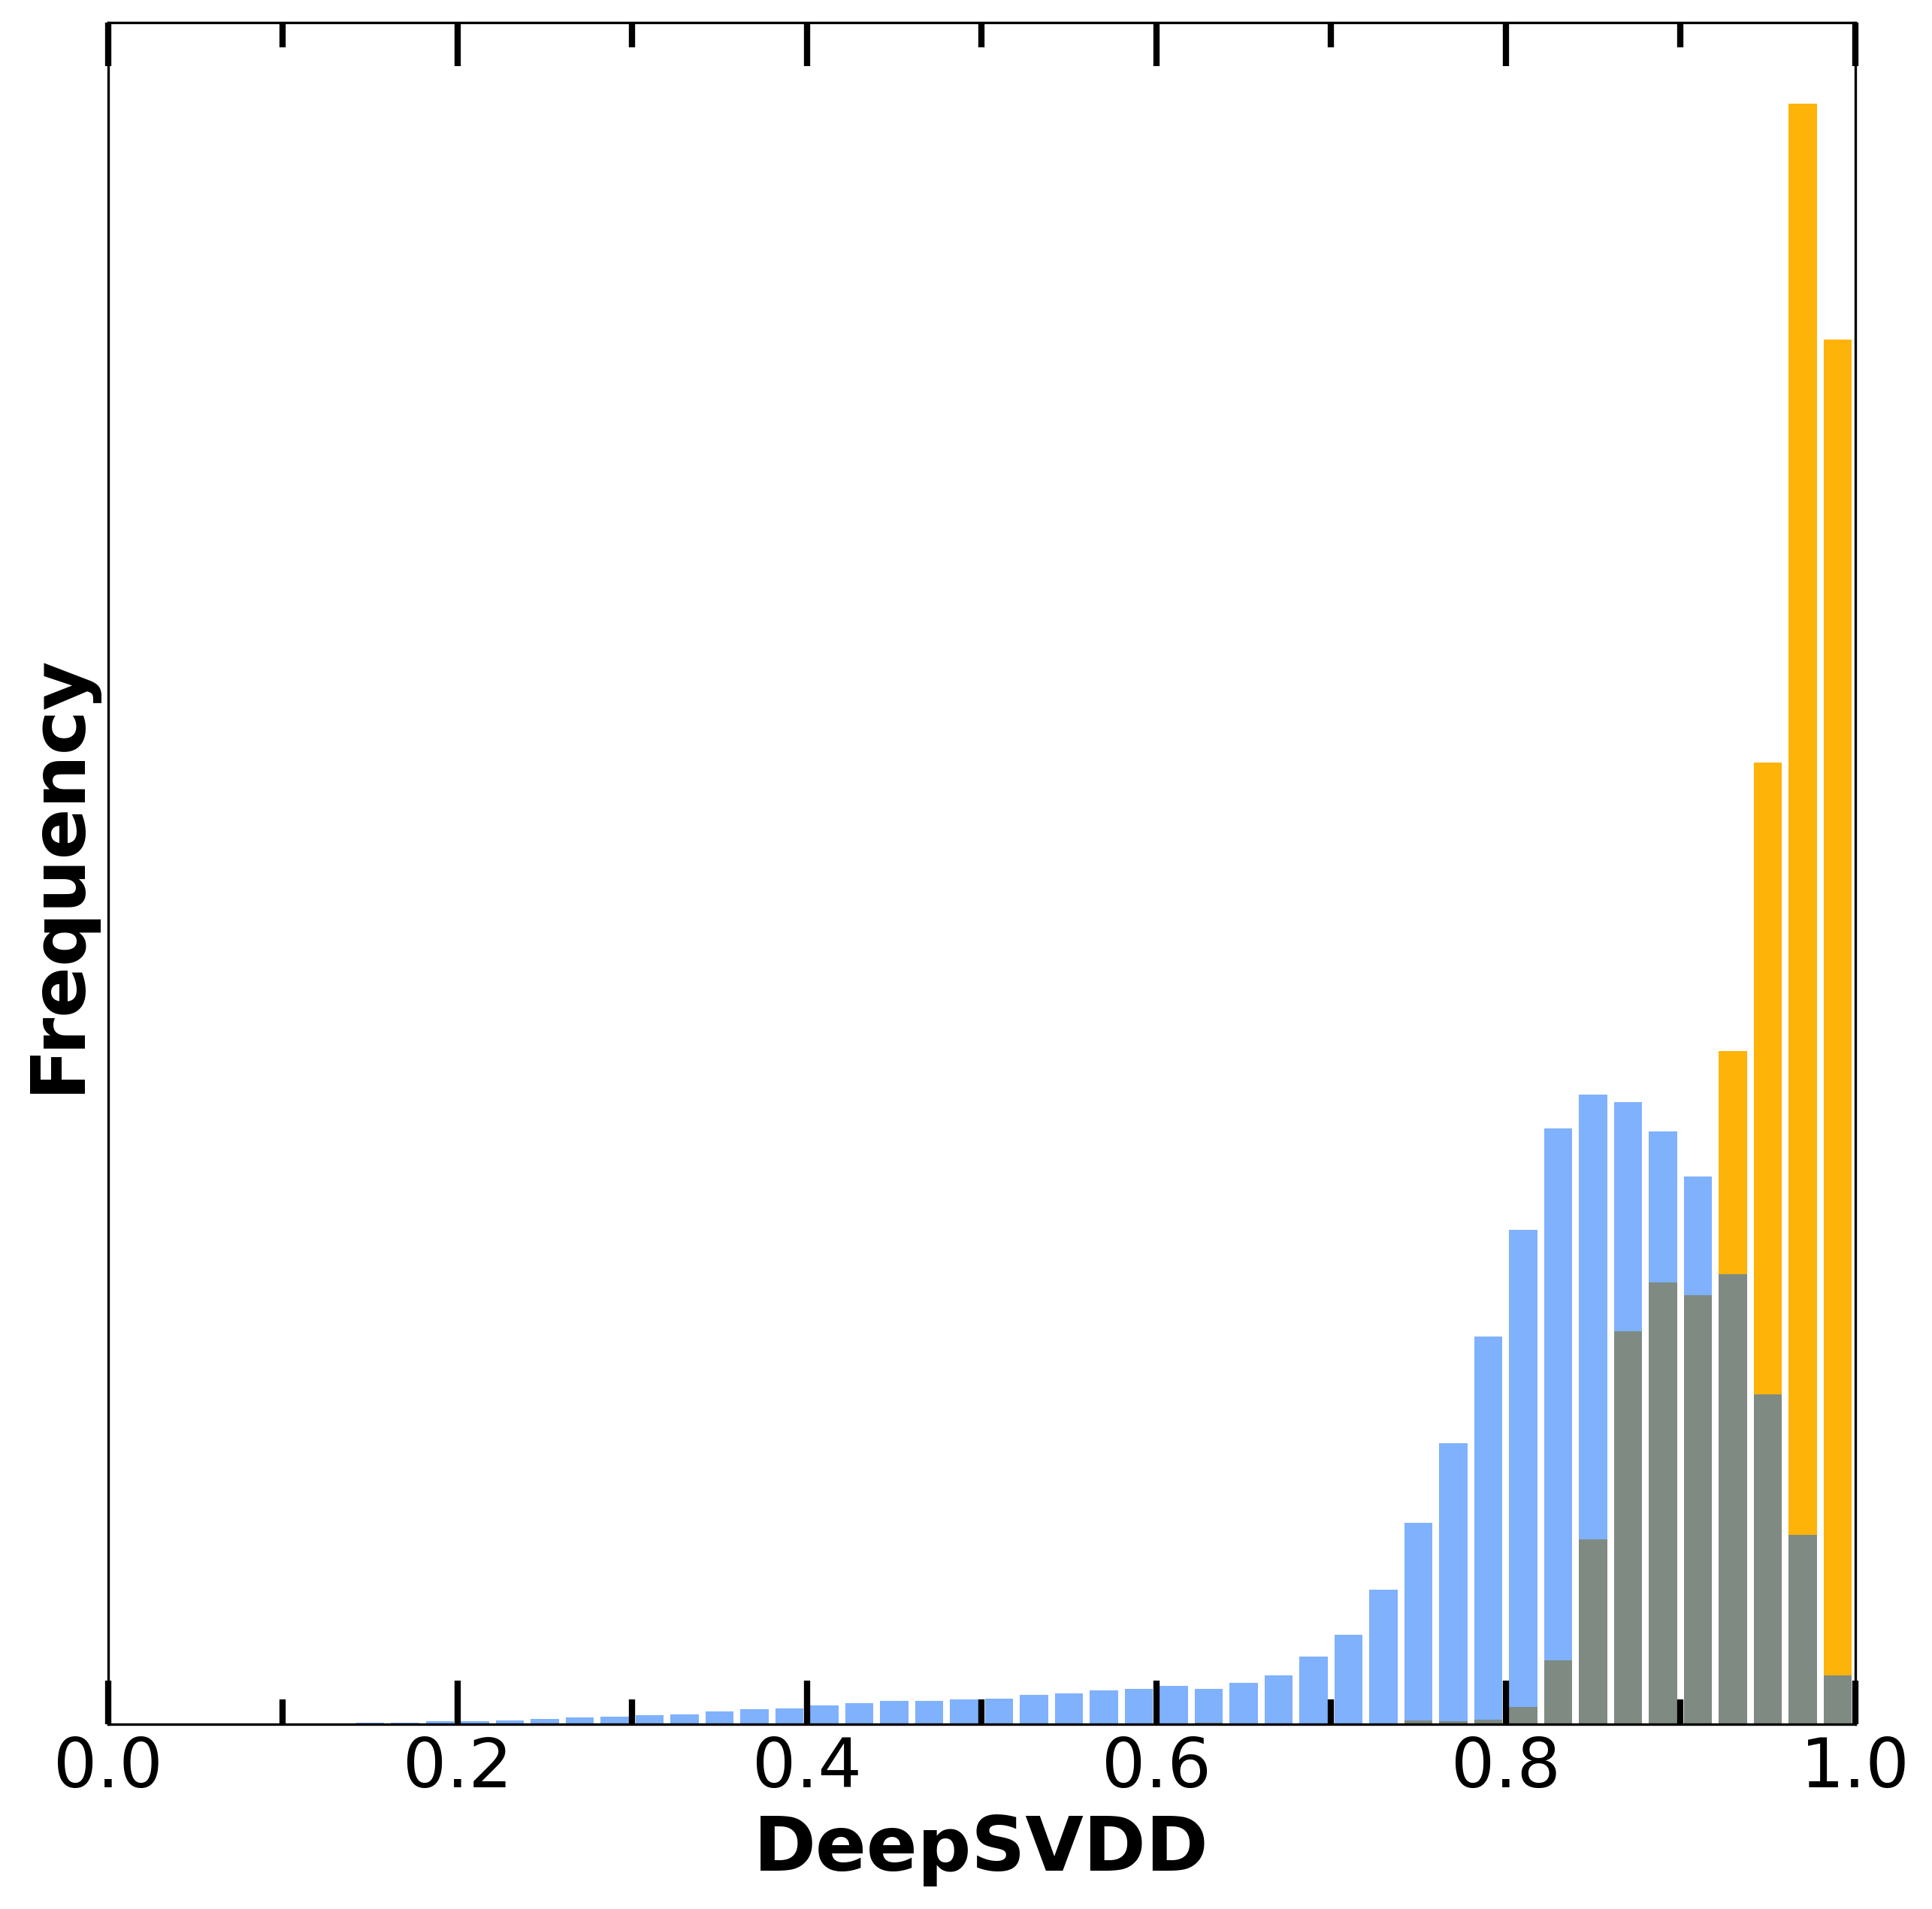

In [4]:
#plot score distributions

#set display colors
A = '#feb308'
B = '#0165fc'

MinMax_scaler = preprocessing.MinMaxScaler()

%matplotlib inline
from matplotlib.pyplot import figure
plt.figure(figsize=(10,10),dpi=300)

for i in np.arange(1):
    # score normalisation
    scores_range = np.concatenate((train_result.iloc[:,i],test_result.iloc[:,i])).reshape(-1,1)
    scores_scaler = MinMax_scaler.fit(scores_range)
    train_scores = scores_scaler.transform(np.array(train_result.iloc[:,i]).reshape(-1,1)) 
    test_scores = scores_scaler.transform(np.array(test_result.iloc[:,i]).reshape(-1,1))
    scores_bins = scores_scaler.transform(scores_range)
    
    ax = plt.subplot(1,1,i+1)
    _, bins , _ = plt.hist(scores_bins, bins=50, density=True, rwidth=0, alpha=0)
    plt.hist(train_scores, bins=bins, rwidth=0.8, histtype='bar', density=True, alpha=1, color=A, label='Ground-truth Dataset')
    _= plt.hist(test_scores[:], bins=bins, density=True, rwidth=0.8, alpha=0.5, color=B, label='Query Dataset') 

    plt.grid(False)
    plt.xlim(0, 1.0)
    plt.xlabel('Your model name', fontsize=24, fontweight='semibold')
    plt.ylabel('Frequency', fontsize=24, fontweight='semibold')
    plt.xticks(fontsize=22)
    plt.yticks([])
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['left'].set_color('black')
    major_ticks_x = np.arange(0, 1.001, 0.2)
    minor_ticks_x = np.arange(0,1.001, 0.1)
    ax.tick_params(axis = 'both', which='both', width=2)
    ax.tick_params(axis = 'both', which='major', length=14)
    ax.tick_params(axis = 'both', which='minor', length=8, color='black')
    ax.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction="in")
    ax.set_xticks(major_ticks_x)
    ax.set_xticks(minor_ticks_x, minor=True)
   
plt.subplots_adjust(wspace=0.1)
plt.show()  

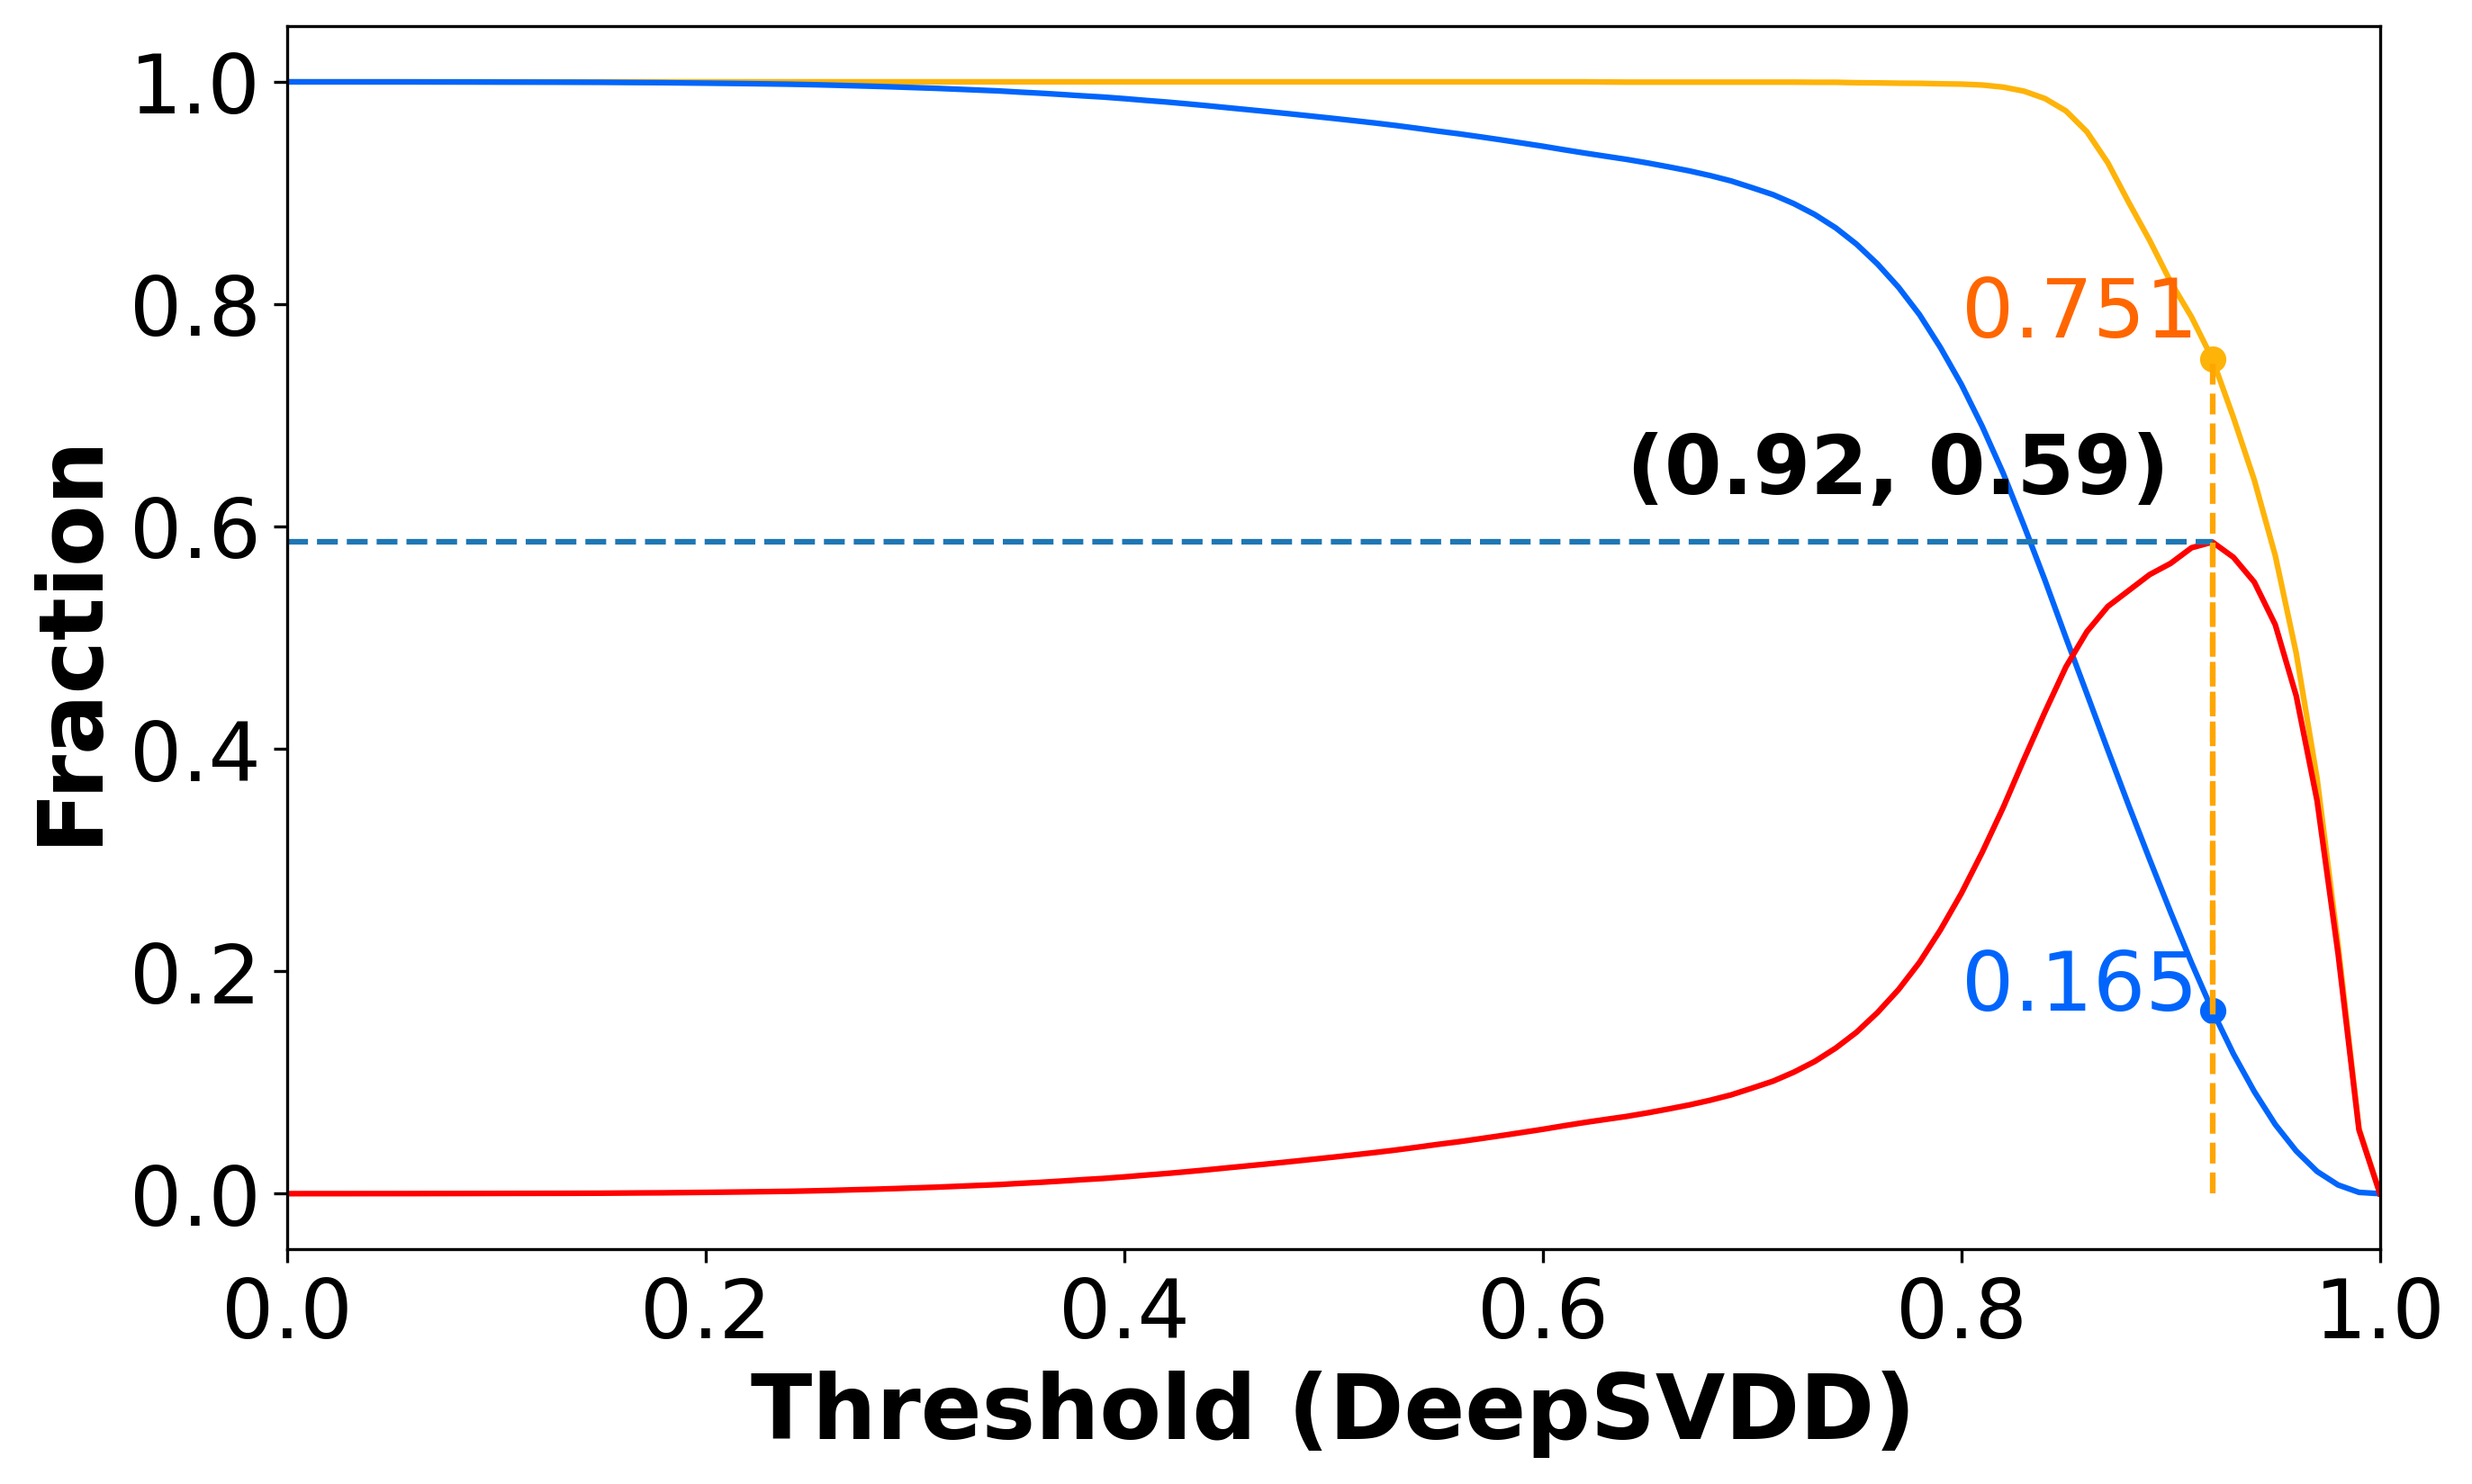

In [5]:
#plot positive fraction distributions
%matplotlib inline
from matplotlib.pyplot import figure
plt.figure(figsize=(10,6),dpi=300)

for i in np.arange(1):
    
    #score normalisation
    scores_range = np.concatenate((train_result.iloc[:,i],test_result.iloc[:,i])).reshape(-1,1)
    scores_scaler = MinMax_scaler.fit(scores_range)
    train_scores = scores_scaler.transform(np.array(train_result.iloc[:,i]).reshape(-1,1)) 
    test_scores = scores_scaler.transform(np.array(test_result.iloc[:,i]).reshape(-1,1))
    
    ax = plt.subplot(1,1,i+1)
    fontsize = 22
    
    #set 100 thresholds between [0,1] 
    iter_num = np.linspace(0.0,1.0,num=101)
    train_fraction = []
    test_fraction = []
    single_eval = []
    
    for i in iter_num:
        threshold = i
        train_count_inlier = np.sum(train_scores >= threshold)
        test_count_inlier = np.sum(test_scores[:] >= threshold)
        train_percent = train_count_inlier/7375
        test_percent = test_count_inlier/160582
        single = train_percent - test_percent
        train_fraction.append(train_percent)
        test_fraction.append(test_percent)
        single_eval.append(single)

    #plot positive fraction distributions for the ground_truth and the query dataset, and the fraction difference between these two datasets
    plt.plot(iter_num,train_fraction,color=A,label='Ground-truth')
    plt.plot(iter_num,test_fraction,color=B,label='Query')
    plt.plot(iter_num,single_eval,color='red',label='Fraction Difference')
    
    #extreme point calculation and labelling
    single_max = max(single_eval)
    temp = single_eval.index(single_max)
    threshold_max = iter_num[temp]
    plt.plot([0,threshold_max],[single_max,single_max], '--')
    plt.plot([threshold_max,threshold_max],[0,single_max], '--', color='orange')
    single_max = round(single_max,2)
    threshold_max = round(threshold_max,3)
    cord =  '('+format(threshold_max, '.2f')+', '+format(single_max,'.2f')+')'
    plt.text(threshold_max-0.28, single_max+0.04, cord, fontsize=fontsize, fontweight='semibold')
    #the positive fraction for the query dataset at the extreme point
    test_max = test_fraction[temp]
    test_max = round(test_max,3)
    plt.scatter(threshold_max, test_max, c=B)
    plt.text(threshold_max-0.12, test_max, test_max, fontsize=fontsize,c='#0165fc')
    #the positive fraction for the ground_truth dataset at the extreme point
    train_max = train_fraction[temp]
    train_max = round(train_max,3)
    plt.scatter(threshold_max, train_max, c=A)
    plt.text(threshold_max-0.12, train_max+0.02, train_max, fontsize=fontsize,c='#ff6600')
    #draw reference line
    refer_min, refer_max = min(train_max, test_max), max(train_max, test_max)
    plt.plot([threshold_max,threshold_max],[refer_min,refer_max], '--', color='orange')
    
    label = 'Threshold (DeepSVDD)'
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.xlabel(label, fontsize=24, fontweight='semibold')
    plt.ylabel('Fraction', fontsize=24, fontweight='semibold')
    plt.xlim(0, 1.0)
    
plt.subplots_adjust(wspace=0.14)    
plt.show()

In [22]:
#the function to calculate MFD(Maximum Fractional Difference) and OT(Optimal Threshold)
def mfd_ot(train_scores, test_scores):
    
    iter_num = np.linspace(0.0,1.0,num=101)
    train_fraction = []
    test_fraction = []
    single_eval = []

    for i in iter_num:
        threshold = i
        train_count_inlier = np.sum(train_scores >= threshold)
        test_count_inlier = np.sum(test_scores[:] >= threshold)
        train_percent = train_count_inlier/len(train_scores)
        test_percent = test_count_inlier/len(test_scores)
        single = train_percent - test_percent
        train_fraction.append(train_percent)
        test_fraction.append(test_percent)
        single_eval.append(single)

    #extreme point
    single_max = max(single_eval)
    temp = single_eval.index(single_max)
    threshold_max = iter_num[temp]
    
    return threshold_max, single_max

ot, mfd = mfd_ot(train_scores, test_scores)
print(ot, mfd)

0.92 0.5860677142825177
